In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy

from scipy.optimize import curve_fit

In [2]:
input_12 = np.loadtxt('sample_st12.txt')
input_18 = np.loadtxt('sample_st18.txt')

x_12 = input_12[:,0].reshape(60,60).transpose()
y_12 = input_12[:,1].reshape(60,60).transpose()
N_12 = input_12[:,2].reshape(60,60).transpose()

x_18 = input_18[:,0].reshape(60,60).transpose()
y_18 = input_18[:,1].reshape(60,60).transpose()
N_18 = input_18[:,2].reshape(60,60).transpose()

x = np.arange(-59,60,2)
y = np.arange(-59,60,2)

x_dist_12 = np.sum(N_12,axis=0)
x_dist_12 /= np.max(x_dist_12)
y_dist_12 = np.sum(N_12,axis=1)
y_dist_12 /= np.max(y_dist_12)

x_dist_18 = np.sum(N_18,axis=0)
x_dist_18 /= np.max(x_dist_18)
y_dist_18 = np.sum(N_18,axis=1)
y_dist_18 /= np.max(y_dist_18)

In [3]:
def _x_dist_long(x, A1, A2, A3, x1, x2, x3, w1, w2, w3):
    f1 = A1 * np.exp(-(x-x1)**2/2/w1**2)
    f2 = A2 * np.exp(-(x-x2)**2/2/w2**2)
    f3 = A3 * np.exp(-(x-x3)**2/2/w3**2)
    return f1+f2+f3

def _y_dist(y, A, y0, wy):
    f1 = np.exp(-(y-y0)**2/2/wy**2)
    return A * f1 / wy / np.sqrt(2*np.pi)

coeffs_x_12, _ = curve_fit(_x_dist_long, x, x_dist_12, p0=[0.17, 0.5, 0.9, -24, -2, 20, 8.3, 12.7, 9.9])
coeffs_x_18, _ = curve_fit(_x_dist_long, x, x_dist_18, p0=[0.17, 0.5, 0.9, -23, -2, 20, 8.3, 12.7, 9.9])

coeffs_y_12, _ = curve_fit(_y_dist, y, y_dist_12, p0=[1, 30, 10])
coeffs_y_18, _ = curve_fit(_y_dist, y, y_dist_18, p0=[1, 30, 10])

## need to find averages, even if they are out of order
## order by center paramters
x_order_12 = np.argsort(coeffs_x_12[3:6])
x_order_18 = np.argsort(coeffs_x_18[3:6])

x23 = ((coeffs_x_12[3:6][x_order_12][1] - coeffs_x_12[3:6][x_order_12][2]
        + coeffs_x_18[3:6][x_order_18][1] - coeffs_x_18[3:6][x_order_18][2])
       / (coeffs_x_12[3:6][x_order_12][0] - coeffs_x_12[3:6][x_order_12][2]
          + coeffs_x_18[3:6][x_order_18][0] - coeffs_x_18[3:6][x_order_18][2]))

w1 = np.abs(coeffs_x_12[6:9][x_order_12][0]/(coeffs_x_12[3:6][x_order_12][0] - coeffs_x_12[3:6][x_order_12][2])
      + coeffs_x_18[6:9][x_order_18][0]/(coeffs_x_18[3:6][x_order_18][0] - coeffs_x_18[3:6][x_order_18][2])
     )/2
w2 = np.abs(coeffs_x_12[6:9][x_order_12][1]/(coeffs_x_12[3:6][x_order_12][0] - coeffs_x_12[3:6][x_order_12][2])
      + coeffs_x_18[6:9][x_order_18][1]/(coeffs_x_18[3:6][x_order_18][0] - coeffs_x_18[3:6][x_order_18][2])
     )/2
w3 = np.abs(coeffs_x_12[6:9][x_order_12][2]/(coeffs_x_12[3:6][x_order_12][0] - coeffs_x_12[3:6][x_order_12][2])
      + coeffs_x_18[6:9][x_order_18][2]/(coeffs_x_18[3:6][x_order_18][0] - coeffs_x_18[3:6][x_order_18][2])
     )/2

A13 = (coeffs_x_12[0:3][x_order_12][0]/coeffs_x_12[0:3][x_order_12][2]
       + coeffs_x_18[0:3][x_order_18][0]/coeffs_x_18[0:3][x_order_18][2]
      )/2
A23 = (coeffs_x_12[0:3][x_order_12][1]/coeffs_x_12[0:3][x_order_12][2]
       + coeffs_x_18[0:3][x_order_18][1]/coeffs_x_18[0:3][x_order_18][2]
      )/2

def _x_dist(x, A, x3, x31):
    f3 = np.exp(-(x-x3)**2/2/(w3*x31)**2)
    f1 = A13 * np.exp(-(x-x3+x31)**2/2/(w1*x31)**2)
    f2 = A23 * np.exp(-(x-x3+x23*x31)**2/2/(w2*x31)**2)
    
    F3 = np.sqrt(2*np.pi) * w3 * x31
    F1 = A13 * np.sqrt(2*np.pi) * w1 * x31
    F2 = A23 * np.sqrt(2*np.pi) * w2 * x31
    
    return A*(f1 + f2 + f3)/(F1+F2+F3)


In [4]:
def _xy_dist_fit(XY, A, x3, x31, y0, wy):
    x, y = XY
    fx = _x_dist(x, 1, x3, x31)
    fy = _y_dist(y, 1, y0, wy)
    return A * fx * fy

def _xy_dist(x, y, A, x3, x31, y0, wy):
    fx = _x_dist(x, 1, x3, x31)
    fy = _y_dist(y, 1, y0, wy)
    return A * fx * fy

In [6]:
## include azimuthal dependence

R0 = 7112

def _x3(theta):  # just a sample, would need to be filled by radial closed orbit
    return 19.4 + 0.05*np.cos(theta)
def _x31(theta):  # needs to be fit by betatron breathing?
    return 45.9 * (1 + 0.05*np.cos(4*theta))
def _y0(theta):  # vertical offset/closed orbit
    return -0.17
def _wy(theta):
    return 13.5 * (1 - 0.1*np.cos(4*theta))

def _xyz_dist(x, y, theta, A):
    x3 = _x3(theta)
    x31 = _x31(theta)
    y0 = _y0(theta)
    wy = _wy(theta)
    return _xy_dist(x, y, 1, x3, x31, y0, wy) / (2*np.pi*R0)  # crappy normalization

def _xyz_integrand(x, y, theta, A):
    return (R0+x) * _xyz_dist(x, y, theta, A)


In [7]:
%%time
## takes ~20 seconds

print scipy.integrate.nquad(_xyz_integrand, [[-60,60],[-60,60],[0,2*np.pi]], args=[1])

(1.000843782249345, 1.4853437684643574e-08)
CPU times: user 8.42 s, sys: 17 ms, total: 8.44 s
Wall time: 8.39 s


In [8]:
%%time

opts = {'epsabs':1.0e-2, 'epsrel':1.0e-3}

print scipy.integrate.nquad(_xyz_integrand, [[-60,60],[-60,60],[0,2*np.pi]], args=[1], opts=opts)

(1.0008437809218271, 0.008624994043847886)
CPU times: user 504 ms, sys: 12 ms, total: 516 ms
Wall time: 479 ms


[ 3.60531293e+07  1.94517004e+01  4.48784407e+01 -1.70286871e-01
  1.35600571e+01]


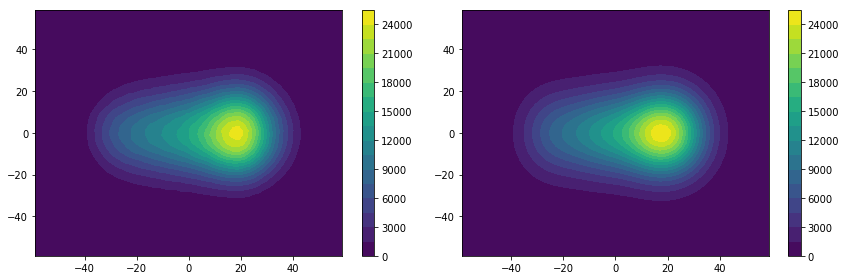

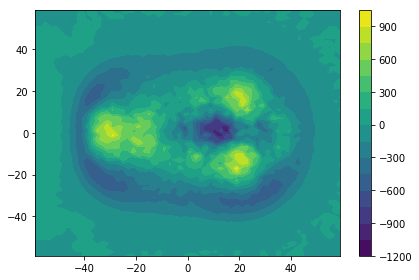

In [9]:
p0 = 8820000, 20, 44, 0, 13
coeffs_xy_12, _ = curve_fit(_xy_dist_fit, (input_12[:,0],input_12[:,1]), input_12[:,2], p0=p0)
print coeffs_xy_12

fig, axs = plt.subplots(1,2)

c1 = axs[0].contourf(x_12, y_12, N_12, 20)
c2 = axs[1].contourf(x_12, y_12, _xy_dist_fit((x_12, y_12), *coeffs_xy_12), 20)
fig.colorbar(c1, ax=axs[0])
fig.colorbar(c2, ax=axs[1])

fig.set_size_inches(12,4)
fig.tight_layout()

fig2, ax2 = plt.subplots(1,1)

c_diff = ax2.contourf(x_12, y_12, N_12 - _xy_dist_fit((x_12, y_12), *coeffs_xy_12), 20)
fig2.colorbar(c_diff)

fig2.set_size_inches(6,4)
fig2.tight_layout()

In [10]:
print scipy.integrate.nquad(_xy_dist, [[-90,90],[-90,90]], args=(1, 20, 44, 0, 13))

print scipy.integrate.dblquad(_xy_dist, -90, 90, lambda x: -90, lambda x: 90, args=(1, 20, 44, 0, 13))

(0.9999999999936976, 1.1847023525445213e-08)
(0.9999999999936976, 1.1847023525445213e-08)


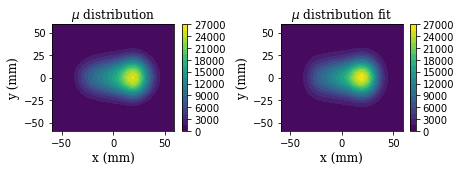

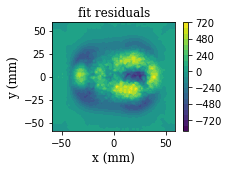

In [27]:
p0 = 8820000, 20, 44, 0, 13
coeffs_xy_18, _ = curve_fit(_xy_dist_fit, (input_18[:,0],input_18[:,1]), input_18[:,2], p0=p0)

fig, axs = plt.subplots(1,2)

c1 = axs[0].contourf(x_18, y_18, N_18, 20)
c2 = axs[1].contourf(x_18, y_18, _xy_dist_fit((x_18, y_18), *coeffs_xy_18), 20)
fig.colorbar(c1, ax=axs[0])
fig.colorbar(c2, ax=axs[1])

for ax in axs:
    ax.set_xlabel('x (mm)', fontdict={'size':12, 'family':'serif'})
    ax.set_ylabel('y (mm)', fontdict={'size':12, 'family':'serif'})
axs[0].set_title('$\mu$ distribution', fontdict={'size':12, 'family':'serif'})
axs[1].set_title('$\mu$ distribution fit', fontdict={'size':12, 'family':'serif'})

fig.set_size_inches(6.5,2.5)
fig.tight_layout()

fig2, ax2 = plt.subplots(1,1)

c_diff = ax2.contourf(x_18, y_18, N_18 - _xy_dist_fit((x_18, y_18), *coeffs_xy_18), 20)
fig2.colorbar(c_diff)

ax2.set_xlabel('x (mm)', fontdict={'size':12, 'family':'serif'})
ax2.set_ylabel('y (mm)', fontdict={'size':12, 'family':'serif'})
ax2.set_title('fit residuals', fontdict={'size':12, 'family':'serif'})

fig2.set_size_inches(3.25,2.5)
fig2.tight_layout()

fig.savefig('2d_fit.png', dpi=300)
fig2.savefig('2d_fit_resid.png', dpi=300)

In [12]:
print coeffs_xy_12

[ 3.60531293e+07  1.94517004e+01  4.48784407e+01 -1.70286871e-01
  1.35600571e+01]


In [13]:
coeffs_12, _ = curve_fit(x_dist, x, x_dist_12)
coeffs_18, _ = curve_fit(x_dist, x, x_dist_18)

NameError: name 'x_dist' is not defined

In [ ]:
print coeffs_12
print coeffs_18

In [ ]:
fig, axs = plt.subplots(2,1)

axs[0].plot(x, x_dist_12, '.')
axs[0].plot(x, x_dist(x, *coeffs_12))

axs[1].plot(x, x_dist_18, '.')
axs[1].plot(x, x_dist(x, *coeffs_18))

fig.set_size_inches(12,8)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,2)
axs[0].contourf(x_st12, y_st12, N_st12, 50)
axs[1].contourf(x_st18, y_st18, N_st18, 50)
fig.set_size_inches(12,6)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(2,1)

axs[0].plot(x_dist_12, '.')
axs[1].plot(y_dist_12, '.')

axs[0].plot(x_dist_18, '.', color='red')
axs[1].plot(y_dist_18, '.', color='red')

fig.set_size_inches(12,6)
fig.tight_layout()

def _x_dist(x, A1, A2, A3, x1, x2, x3, w1, w2, w3):
    f1 = A1 * np.exp(-(x-x1)**2/2/w1**2)
    f2 = A2 * np.exp(-(x-x2)**2/2/w2**2)
    f3 = A3 * np.exp(-(x-x3)**2/2/w3**2)
    return f1+f2+f3

def _y_dist(x, A1, x1, w1):
    f1 = A1 * np.exp(-(x-x1)**2/2/w1**2)
    return f1

x_fit = np.arange(0,60)
y_fit = np.arange(0,60)

coeffs_x_12, _ = curve_fit(_x_dist, x_fit, x_dist_12, p0=np.array([0.3, 0.3, 0.3, 20, 30, 40, 10, 10, 10]))
axs[0].plot(x_fit, _x_dist(x_fit, *coeffs_x_12), color='blue')

coeffs_x_18, _ = curve_fit(_x_dist, x_fit, x_dist_18, p0=np.array([0.3, 0.3, 0.3, 20, 30, 40, 10, 10, 10]))
axs[0].plot(x_fit, _x_dist(x_fit, *coeffs_x_18), color='red')

coeffs_y_12, _ = curve_fit(_y_dist, y_fit, y_dist_12, p0=[1, 30, 10])
axs[1].plot(y_fit, _y_dist(y_fit, *coeffs_y_12), color='blue')

coeffs_y_18, _ = curve_fit(_y_dist, y_fit, y_dist_18, p0=[1, 30, 10])
axs[1].plot(y_fit, _y_dist(y_fit, *coeffs_y_18), color='red')

In [14]:
print coeffs_x_12
print coeffs_x_18

print (coeffs_x_12[1]/coeffs_x_12[2] + coeffs_x_18[1]/coeffs_x_18[2])/2
print (coeffs_x_12[0]/coeffs_x_12[2] + coeffs_x_18[0]/coeffs_x_18[2])/2

print (coeffs_x_12[5] - coeffs_x_12[4] + coeffs_x_18[5] - coeffs_x_18[4])/2
print (coeffs_x_12[5] - coeffs_x_12[3] + coeffs_x_18[5] - coeffs_x_18[3])/2

print (coeffs_x_12[7]/coeffs_x_12[8] + coeffs_x_18[7]/coeffs_x_18[8])/2
print (coeffs_x_12[6]/coeffs_x_12[8] + coeffs_x_18[6]/coeffs_x_18[8])/2

[  0.17305174   0.50325657   0.85368057 -24.76538518  -2.46282592
  19.88228096   7.99053625  13.57313577   9.61525844]
[  0.17817801   0.45776299   0.91598508 -22.74572061  -2.56472529
  20.25723237   8.66447535  11.7944942   10.21659785]
0.5446316496706988
0.19861658162656168
22.583532264096405
43.82530955522893
1.2830345228177837
0.8395525073893939


In [15]:
def x_dist(x, A, x0, w):  # x0 is position of third peak, w is width of third peak
    f1 = np.exp(-(x-x0)**2/2/w**2)
    f2 = 0.54*np.exp(-(x-x0+11.3)**2/2/(1.3*w)**2)
    f3 = 0.2*np.exp(-(x-x0+21.9)**2/2/(0.84*w)**2)
    return A*(f1+f2+f3)

NameError: name 'x_fit' is not defined

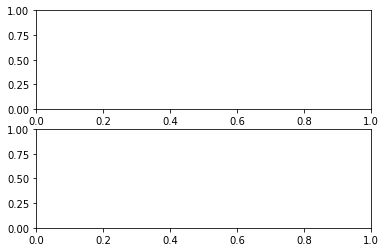

In [16]:
fig, axs = plt.subplots(2,1)

coeffs_2_x_12, _ = curve_fit(x_dist, x_fit, x_dist_12, p0=[1, 40, 5])
axs[0].plot(x_fit, x_dist(x_fit, *coeffs_2_x_12), color='blue')

axs[0].plot(x_fit, x_dist_12, '.')

coeffs_2_x_18, _ = curve_fit(x_dist, x_fit, x_dist_18, p0=[1, 40, 5])
axs[1].plot(x_fit, x_dist(x_fit, *coeffs_2_x_18), color='red')

axs[1].plot(x_fit, x_dist_18, '.', color='red')

fig.set_size_inches(12,6)
fig.tight_layout()

In [ ]:
## 2D dist, x*y

def xy_dist(x, y, A, x0, y0, wx, wy):
    fx = x_dist(x, 1, x0, wx)
    fy = _y_dist(y, 1, y0, wy)
    return A * fx * fy

In [ ]:
print coeffs_y_12

In [ ]:
fig, ax = plt.subplots(1,1)

X, Y = np.meshgrid(np.arange(0,60), np.arange(0,60))

ax.contourf(X, Y, xy_dist(X, Y, 1., 40., 30., 5., 6.7), 50)
# ax.plot(y_fit, _y_dist(y_fit, 1, 30, 20))

fig.set_size_inches(8,8)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(2,1)

axs[0].plot(np.log(np.sum(N_st12,axis=0)/np.max(np.sum(N_st12,axis=0))), '.')
axs[1].plot(np.log(np.sum(N_st12,axis=1)/np.max(np.sum(N_st12,axis=1))), '.')

axs[0].plot(np.log(np.sum(N_st18,axis=0)/np.max(np.sum(N_st18,axis=0))), '.', color='red')
axs[1].plot(np.log(np.sum(N_st18,axis=1)/np.max(np.sum(N_st18,axis=1))), '.', color='red')

fig.set_size_inches(12,6)
fig.tight_layout()